Model comparison, rigorous investigation of PCA/no PCA, with rate variables/without rate variables using the imputed dataset at a 25% threshold

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model

In [3]:
# https://www.kaggle.com/tunguz/deep-solar-dataset
# df_all = pd.read_csv('deepsolar_tract.csv', encoding='latin-1')
df_all = pd.read_csv('cleaned_solar_tract_25.csv', encoding = 'latin-1')

In [6]:
for col in df_all.columns:
    try:
        pd.to_numeric(df_all[col])
    except:
        print(col)

In [7]:
df = df_all.loc[:, ~(df_all.columns).isin(['voting_2012_dem_percentage', 'voting_2012_gop_percentage'])]
df =df.dropna()

In [9]:
# Create some variables
df['income_per_area_residential'] = df['average_household_income']*df['household_count'].div(df.land_area)
df['household_density'] = df['household_count'].div(df.land_area)
df['education_higher_ed'] = (df['education_bachelor'] + df['education_doctoral'] + df['education_master'] + df['education_professional_school'])
df['house_val_rel_to_med_income'] = df['housing_unit_median_value'].div(df.median_household_income)

In [11]:
# 1.) pull out columns that contain strings, solar variables (except target), nonresidential variables

misc = ['Unnamed: 0','fips', 'county', 'state']
solar = ['total_panel_area',  'total_panel_area_residential', 'total_panel_area_nonresidential',  
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                'tile_count','tile_count_residential', 'tile_count_nonresidential','number_of_solar_system_per_household', 
                   'solar_system_count','solar_system_count_nonresidential']
non_residential = ['electricity_price_transportation','incentive_count_nonresidential',
                   'electricity_consume_commercial','electricity_price_overall', 'electricity_consume_industrial', 
                   'electricity_consume_total','electricity_price_industrial','electricity_price_commercial']

df = df.loc[:, ~(df.columns).isin(misc + solar + non_residential)]


In [ ]:
# 1.) Split data

In [12]:
X = df#.loc[:, ~(df.columns).isin([target])]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [110]:
# 2.) Next, scale data

In [14]:
def split_scale_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    sclr = StandardScaler()
    sclr.fit(X_train[X_train.columns])

    X_train_scaled = pd.DataFrame(sclr.transform(X_train[X_train.columns]), columns = X_train.columns)
    X_test_scaled = pd.DataFrame(sclr.transform(X_test[X_test.columns]), columns = X_test.columns)

    y_train_scaled = X_train_scaled[target]
    X_train_scaled = X_train_scaled.loc[:, ~(X_train_scaled.columns).isin([target])]

    y_test_scaled = X_test_scaled[target]
    X_test_scaled = X_test_scaled.loc[:, ~(X_test_scaled.columns).isin([target])]
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, sclr

In [ ]:
X = df.loc[:, ~(df.columns).isin([target])]
y = df[target]

In [96]:
edu_omit = ['education_bachelor','education_college','education_doctoral','education_high_school_graduate','education_less_than_high_school','education_master','education_professional_school']
race_omit = ['race_asian','race_black_africa','race_indian_alaska','race_islander','race_other','race_two_more','race_white', 'race_indian_alaska_rate','race_two_more_rate']
heat_fuel_omit = ['heating_fuel_coal_coke','heating_fuel_electricity','heating_fuel_fuel_oil_kerosene','heating_fuel_gas','heating_fuel_housing_unit_count',
'heating_fuel_none','heating_fuel_other','heating_fuel_solar', 'heating_fuel_solar_rate']


edu_rate_omit = ['education_bachelor_rate','education_college_rate','education_doctoral_rate','education_high_school_graduate_rate','education_less_than_high_school_rate','education_master_rate','education_professional_school_rate']
race_rate_omit = ['race_asian_rate','race_black_africa_rate','race_indian_alaska_rate','race_islander_rate','race_other_rate','race_two_more_rate','race_white_rate','race_indian_alaska','race_two_more']
heat_fuel_rate_omit = ['heating_fuel_coal_coke_rate','heating_fuel_electricity_rate','heating_fuel_fuel_oil_kerosene_rate','heating_fuel_gas_rate','heating_fuel_housing_unit_count_rate',
'heating_fuel_none_rate','heating_fuel_other_rate','heating_fuel_solar_rate', 'heating_fuel_solar']


In [ ]:
# 3.) Consider model options: Linear Regression, Random Forest Regression, SVM-R, Gradient Boosting Regression

In [21]:
import time
from sklearn.svm import SVR
from sklearn import ensemble

params = {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}

d_model = {'lin_reg': linear_model.LinearRegression(), 'lasso': linear_model.Lasso(), 'ridge': linear_model.Ridge(), 
           'svr': SVR(), 'clf': ensemble.GradientBoostingRegressor(**params), 'rfr': ensemble.RandomForestRegressor(max_depth=6, random_state=0, n_estimators=200)}

d_data = {}
d_results = {ik: {model:{} for model in d_model.keys()} for ik in range(3)}
# d_results = {model: {ik:{} for ik in range(5)} for model in d_model.keys()}
d_train_test_scale_pca={ik:{} for ik in range(3)}


# Model comparison  

Splits data, trains a scaler & pca  
Runs each of six models with six cross validations each  
Stores data and model output

## With PCA

In [71]:
ik = 0 
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, sclr = split_scale_data(X, y)
pca = PCA(n_components=100)
pca.fit(X_train_scaled)
d_train_test_scale_pca[ik] = {'X_train_scaled':X_train_scaled, 'X_test_scaled':X_test_scaled, 
                              'y_train_scaled':y_train_scaled, 'y_test_scaled':y_test_scaled,
                              'sclr': sclr, 'pca':pca}

# X_train_scaled= d_train_test_scale_pca[ik]['X_train_scaled']
# X_test_scaled= d_train_test_scale_pca[ik]['X_test_scaled']
# y_train_scaled= d_train_test_scale_pca[ik]['y_train_scaled']
# y_test_scaled=d_train_test_scale_pca[ik]['y_test_scaled']
# pca = d_train_test_scale_pca[ik]['pca']


print('Set:', ik)
for model in d_model.keys():
    print(model)
    model_inst = d_model[model]
    start_fit = time.time()
    model_inst.fit(pca.transform(X_train_scaled), y_train_scaled)
    end_fit = time.time()
    print('fit time:', (end_fit-start_fit)/60)
    start_cv = time.time()
    cross_val_scores = cross_val_score(model_inst, pca.transform(X_train_scaled),y_train_scaled, cv = 6 )
    end_cv = time.time()
    start_pred = time.time()
    preds = model_inst.predict(pca.transform(X_test_scaled))
    end_pred = time.time()
    test_score = model_inst.score(pca.transform(X_test_scaled), y_test_scaled)
    print('cross_val_scores', cross_val_scores, 'test score:', test_score)
    d_results[ik][model] = {'model_handle': model, 'model': model_inst, 
                            'train_time': end_fit-start_fit,
                            'cv_scores': cross_val_scores, 'cv_avg': np.mean(cross_val_scores), 'cv_std': np.std(cross_val_scores), 'cv_time': end_cv-start_cv,
                            'preds': preds, 'pred_time': end_pred-start_pred, 
                            'test_score': test_score}

    
    

Set: 2
rfr
fit time: 7.338004318873088
cross_val_scores [ 0.4643563   0.50163764  0.46801     0.46977475  0.49772574  0.51027446] test score: 0.460127815763


Reports summary statistics about model runs

In [74]:
for model in ['ridge', 'svr', 'clf', 'rfr']:
    print(model)
    cv_scores = []
    scores = []
    fit_times = []
    for ik in range(3):
#         print(d_results[ik][model].keys())
#         break
        fit_times.append(d_results[ik][model]['train_time'])
        scores.append(d_results[ik][model]['test_score'])
        cv_scores.append(d_results[ik][model]['cv_scores'])
        print('cv_scores',ik,':', d_results[ik][model]['cv_avg'],d_results[ik][model]['cv_std'])
    cv_scores2 = np.concatenate(cv_scores)
    print('all_CV_mean:', cv_scores2.mean(), 'all_CV_std:', cv_scores2.std())
    print('test_scores_mean:', np.mean(scores), 'test_scores_std:', np.std(scores))
    print('mean fit time:', np.mean(fit_times), 'fit time std:', np.std(fit_times))
    print('\n')

ridge
cv_scores 0 : 0.435549676552 0.0279145511462
cv_scores 1 : 0.434164140538 0.0119138806937
cv_scores 2 : 0.430996877149 0.0313180537436
all_CV_mean: 0.433102348819 all_CV_std: 0.0264765867529
test_scores_mean: 0.445091567277 test_scores_std: 0.00417284204364
mean fit time: 0.154432296753 fit time std: 0.0064262175767


svr
cv_scores 0 : 0.607999788833 0.0291929480613
cv_scores 1 : 0.623333988254 0.0415598211115
cv_scores 2 : 0.62749403949 0.0299759158784
all_CV_mean: 0.621042866246 all_CV_std: 0.0343316975353
test_scores_mean: 0.594243782764 test_scores_std: 0.022272830875
mean fit time: 1961.61359239 fit time std: 25.6496728251


clf
cv_scores 0 : 0.660504360264 0.0352356610108
cv_scores 1 : 0.640818741732 0.00773856874242
cv_scores 2 : 0.654487326865 0.0343865792347
all_CV_mean: 0.652400540029 all_CV_std: 0.0308039241531
test_scores_mean: 0.646674947854 test_scores_std: 0.0115519048002
mean fit time: 669.219101032 fit time std: 6.60384805089


rfr
cv_scores 0 : 0.474014056448 0.

# Non PCA

In [75]:
d_results_nopca = {ik: {model:{} for model in d_model.keys()} for ik in range(3)}

In [77]:
ik = 0

X_train_scaled= d_train_test_scale_pca[ik]['X_train_scaled']
X_test_scaled= d_train_test_scale_pca[ik]['X_test_scaled']
y_train_scaled= d_train_test_scale_pca[ik]['y_train_scaled']
y_test_scaled=d_train_test_scale_pca[ik]['y_test_scaled']

for model in d_model.keys():
    print(model)
    model_inst = d_model[model]
    start_fit = time.time()
    model_inst.fit(X_train_scaled, y_train_scaled)
    end_fit = time.time()
    start_cv = time.time()
    cross_val_scores = cross_val_score(model_inst, X_train_scaled,y_train_scaled, cv = 6 )
    end_cv = time.time()
    start_pred = time.time()
    preds = model_inst.predict(X_test_scaled)
    end_pred = time.time()
    test_score = model_inst.score(X_test_scaled, y_test_scaled)
    print('cross_val_scores', cross_val_scores, 'test score:', test_score)
    d_results_nopca[ik][model] = {'model_handle': model, 'model': model_inst, 
                            'train_time': end_fit-start_fit,
                            'cv_scores': cross_val_scores, 'cv_avg': np.mean(cross_val_scores), 'cv_std': np.std(cross_val_scores), 'cv_time': end_cv-start_cv,
                            'preds': preds, 'pred_time': end_pred-start_pred, 
                            'test_score': test_score}

    
    

lin_reg
cross_val_scores [ 0.4895838   0.46440664  0.43686287  0.46560961  0.46345822  0.46023279] test score: 0.495879038128
lasso
cross_val_scores [ -3.76336342e-05  -1.20282803e-04  -8.40136090e-08  -4.46191633e-05
  -1.83361255e-04  -2.96138343e-04] test score: -5.68276553814e-07
ridge
cross_val_scores [ 0.48970604  0.46443713  0.43706653  0.46570507  0.46334915  0.46037631] test score: 0.495789651546
svr


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

cross_val_scores [ 0.5741759   0.69761075  0.60045015  0.64277393  0.65071582  0.62842841] test score: 0.600243726857
clf
cross_val_scores [ 0.79900807  0.80560109  0.74119944  0.73540472  0.77175446  0.79779699] test score: 0.757733397434
rfr
cross_val_scores [ 0.66400584  0.64839395  0.60402937  0.63832099  0.64266542  0.66182013] test score: 0.64501775968


In [79]:
for model in ['ridge', 'svr', 'clf', 'rfr']:
    print(model)
    cv_scores = []
    scores = []
    fit_times = []
    for ik in range(3):
#         print(d_results[ik][model].keys())
#         break
        fit_times.append(d_results_nopca[ik][model]['train_time'])
        scores.append(d_results_nopca[ik][model]['test_score'])
        cv_scores.append(d_results_nopca[ik][model]['cv_scores'])
        print('cv_scores',ik,':', d_results_nopca[ik][model]['cv_avg'],d_results_nopca[ik][model]['cv_std'])
    cv_scores2 = np.concatenate(cv_scores)
    print('all_CV_mean:', cv_scores2.mean(), 'all_CV_std:', cv_scores2.std())
    print('test_scores_mean:', np.mean(scores), 'test_scores_std:', np.std(scores))
    print('mean fit time:', np.mean(fit_times), 'fit time std:', np.std(fit_times))
    print('\n')

ridge
cv_scores 0 : 0.469928955006 0.0314182472772
cv_scores 1 : 0.46344004056 0.0152806194958
cv_scores 2 : 0.469257023215 0.0116647028795
all_CV_mean: 0.467542006261 all_CV_std: 0.0214641858103
test_scores_mean: 0.479760108488 test_scores_std: 0.011753253122
mean fit time: 0.110681851705 fit time std: 0.0469390740039


svr
cv_scores 0 : 0.619412210514 0.0253409549543
cv_scores 1 : 0.632359158246 0.0389917328815
cv_scores 2 : 0.63033728034 0.0104348750817
all_CV_mean: 0.6273695497 all_CV_std: 0.0280976197959
test_scores_mean: 0.608349782583 test_scores_std: 0.0174930106436
mean fit time: 1452.53420242 fit time std: 25.5284679079


clf
cv_scores 0 : 0.776597758259 0.0200706147268
cv_scores 1 : 0.775127460573 0.0281460976921
cv_scores 2 : 0.772515215667 0.0145169462042
all_CV_mean: 0.774746811499 all_CV_std: 0.0217127077652
test_scores_mean: 0.770982951009 test_scores_std: 0.00964650326174
mean fit time: 569.705854336 fit time std: 2.04361803094


rfr
cv_scores 0 : 0.636549219035 0.0287

## Non PCA, No Rates  
Ran the below tests only with gradient boosting regression given the performance was so much better

In [80]:
edu_rate_omit = ['education_bachelor_rate','education_college_rate','education_doctoral_rate','education_high_school_graduate_rate','education_less_than_high_school_rate','education_master_rate','education_professional_school_rate']
race_rate_omit = ['race_asian_rate','race_black_africa_rate','race_indian_alaska_rate','race_islander_rate','race_other_rate','race_two_more_rate','race_white_rate','race_indian_alaska','race_two_more']
heat_fuel_rate_omit = ['heating_fuel_coal_coke_rate','heating_fuel_electricity_rate','heating_fuel_fuel_oil_kerosene_rate','heating_fuel_gas_rate','heating_fuel_housing_unit_count_rate',
'heating_fuel_none_rate','heating_fuel_other_rate','heating_fuel_solar_rate', 'heating_fuel_solar']


In [81]:
d_results_nopca_no_ratefeatures = {ik: {model:{} for model in d_model.keys()} for ik in range(3)}

In [85]:
ik = 0

X_train_scaled= d_train_test_scale_pca[ik]['X_train_scaled']
X_test_scaled= d_train_test_scale_pca[ik]['X_test_scaled']
y_train_scaled= d_train_test_scale_pca[ik]['y_train_scaled']
y_test_scaled=d_train_test_scale_pca[ik]['y_test_scaled']

X_train_scaled_no_ratefeatures = X_train_scaled.loc[:, ~(X_train_scaled.columns).isin(edu_rate_omit + race_rate_omit + heat_fuel_rate_omit)]
X_test_scaled_no_ratefeatures = X_test_scaled.loc[:, ~(X_test_scaled.columns).isin(edu_rate_omit + race_rate_omit + heat_fuel_rate_omit)]
y_train_scaled_no_ratefeatures = y_train_scaled
y_test_scaled_no_ratefeatures = y_test_scaled

for model in ['clf']:
    print(model)
    model_inst = d_model[model]
    start_fit = time.time()
    model_inst.fit(X_train_scaled_no_ratefeatures, y_train_scaled_no_ratefeatures)
    end_fit = time.time()
    start_cv = time.time()
    cross_val_scores = cross_val_score(model_inst, X_train_scaled_no_ratefeatures,y_train_scaled_no_ratefeatures, cv = 6 )
    end_cv = time.time()
    start_pred = time.time()
    preds = model_inst.predict(X_test_scaled_no_ratefeatures)
    end_pred = time.time()
    test_score = model_inst.score(X_test_scaled_no_ratefeatures, y_test_scaled_no_ratefeatures)
    print('cross_val_scores', cross_val_scores, 'test score:', test_score)
    d_results_nopca_no_ratefeatures[ik][model] = {'model_handle': model, 'model': model_inst, 
                            'train_time': end_fit-start_fit,
                            'cv_scores': cross_val_scores, 'cv_avg': np.mean(cross_val_scores), 'cv_std': np.std(cross_val_scores), 'cv_time': end_cv-start_cv,
                            'preds': preds, 'pred_time': end_pred-start_pred, 
                            'test_score': test_score}

    
    

clf
cross_val_scores [ 0.7389969   0.79162182  0.76237418  0.76295318  0.77094949  0.77511957] test score: 0.773114849937


In [87]:
for model in ['clf']:
    print(model)
    cv_scores = []
    scores = []
    fit_times = []
    for ik in range(3):
#         print(d_results[ik][model].keys())
#         break
        fit_times.append(d_results_nopca_no_ratefeatures[ik][model]['train_time'])
        scores.append(d_results_nopca_no_ratefeatures[ik][model]['test_score'])
        cv_scores.append(d_results_nopca_no_ratefeatures[ik][model]['cv_scores'])
        print('cv_scores',ik,':', d_results_nopca_no_ratefeatures[ik][model]['cv_avg'],d_results_nopca_no_ratefeatures[ik][model]['cv_std'])
    cv_scores2 = np.concatenate(cv_scores)
    print('all_CV_mean:', cv_scores2.mean(), 'all_CV_std:', cv_scores2.std())
    print('test_scores_mean:', np.mean(scores), 'test_scores_std:', np.std(scores))
    print('mean fit time:', np.mean(fit_times), 'fit time std:', np.std(fit_times))
    print('\n')

clf
cv_scores 0 : 0.774678445639 0.0196291367666
cv_scores 1 : 0.771400113721 0.0261255071823
cv_scores 2 : 0.767002523758 0.0158624730291
all_CV_mean: 0.771027027706 all_CV_std: 0.0212063816217
test_scores_mean: 0.770916860798 test_scores_std: 0.00327514488383
mean fit time: 584.154321988 fit time std: 69.4414455682




# Gradient Descent GridSearchCV

In [88]:
params = {'loss': ['ls', 'huber'], 
         'verbose': [10], 
          'max_depth':[3,6],
          'n_estimators':[400,500],
          'learning_rate': [.01, .1],
         'min_samples_split': [2,4]}
         #'subsample': [.6, 1],
         #'criterion': ['friedman_mse', 'mae'],
         #'max_depth': [2,3,6],
         #}

import time
start = time.time()
gbr = ensemble.GradientBoostingRegressor(**params)
clf_gs = GridSearchCV(gbr, params, cv = 4, n_jobs= -1)
clf_gs.fit(X_train_scaled, y_train_scaled)
score = clf_gs.score(X_test_scaled, y_test_scaled)
print(clf_gs.best_estimator_, score)
end = time.time()
total_time = end-start
print('total time:', total_time)

      Iter       Train Loss   Remaining Time 
         1           0.8742           11.74m
         2           0.7723           11.22m
         3           0.6886           11.00m
         4           0.6163           11.09m
         5           0.5594           11.24m
         6           0.5062           11.19m
         7           0.4638           11.30m
         8           0.4229           11.24m
         9           0.3919           11.22m
        10           0.3633           11.16m
        11           0.3357           11.11m
        12           0.3153           11.09m
        13           0.2957           11.04m
        14           0.2789           10.97m
        15           0.2639           10.96m
        16           0.2503           10.92m
        17           0.2397           10.88m
        18           0.2271           10.84m
        19           0.2179           10.82m
        20           0.2101           10.82m
        21           0.2018           10.76m
        2

       183           0.0545            5.30m
       184           0.0540            5.27m
       185           0.0538            5.25m
       186           0.0536            5.22m
       187           0.0535            5.19m
       188           0.0531            5.17m
       189           0.0529            5.15m
       190           0.0526            5.13m
       191           0.0523            5.11m
       192           0.0522            5.08m
       193           0.0521            5.05m
       194           0.0517            5.03m
       195           0.0515            5.00m
       196           0.0512            4.98m
       197           0.0510            4.96m
       198           0.0509            4.93m
       199           0.0507            4.91m
       200           0.0506            4.88m
       201           0.0504            4.85m
       202           0.0502            4.83m
       203           0.0500            4.80m
       204           0.0498            4.78m
       205

       366           0.0287           50.01s
       367           0.0287           48.55s
       368           0.0286           47.10s
       369           0.0285           45.64s
       370           0.0284           44.15s
       371           0.0283           42.67s
       372           0.0282           41.18s
       373           0.0282           39.68s
       374           0.0282           38.20s
       375           0.0280           36.75s
       376           0.0279           35.29s
       377           0.0279           33.81s
       378           0.0278           32.32s
       379           0.0278           30.86s
       380           0.0277           29.38s
       381           0.0277           27.89s
       382           0.0276           26.42s
       383           0.0276           24.93s
       384           0.0276           23.46s
       385           0.0275           21.99s
       386           0.0274           20.53s
       387           0.0273           19.06s
       388

## Final set of runs with optimized model

In [90]:
d_results_nopca_bestmodel = {ik: {model:{} for model in d_model.keys()} for ik in range(3)}

In [96]:
ik = 2
# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, sclr = split_scale_data(X, y)
# pca = PCA(n_components=100)
# pca.fit(X_train_scaled)
# d_train_test_scale_pca[ik] = {'X_train_scaled':X_train_scaled, 'X_test_scaled':X_test_scaled, 
#                               'y_train_scaled':y_train_scaled, 'y_test_scaled':y_test_scaled,
#                               'sclr': sclr, 'pca':pca}

X_train_scaled= d_train_test_scale_pca[ik]['X_train_scaled']
X_test_scaled= d_train_test_scale_pca[ik]['X_test_scaled']
y_train_scaled= d_train_test_scale_pca[ik]['y_train_scaled']
y_test_scaled=d_train_test_scale_pca[ik]['y_test_scaled']

# X_train_scaled_no_ratefeatures = X_train_scaled.loc[:, ~(X_train_scaled.columns).isin(edu_rate_omit + race_rate_omit + heat_fuel_rate_omit)]
# X_test_scaled_no_ratefeatures = X_test_scaled.loc[:, ~(X_test_scaled.columns).isin(edu_rate_omit + race_rate_omit + heat_fuel_rate_omit)]
# y_train_scaled_no_ratefeatures = y_train_scaled
# y_test_scaled_no_ratefeatures = y_test_scaled



for model in ['clf']:
    print(model)
    model_inst = clf_gs.best_estimator_
    start_fit = time.time()
    model_inst.fit(X_train_scaled, y_train_scaled)
    end_fit = time.time()
    test_score = model_inst.score(X_test_scaled, y_test_scaled)
    print('test score:', test_score)
    start_cv = time.time()
    cross_val_scores = cross_val_score(model_inst, X_train_scaled,y_train_scaled, cv = 6 )
    end_cv = time.time()
    start_pred = time.time()
    preds = model_inst.predict(X_test_scaled)
    end_pred = time.time()
    print('cross_val_scores', cross_val_scores, 'test score:', test_score)
    d_results_nopca_bestmodel[ik][model] = {'model_handle': model, 'model': model_inst, 
                            'train_time': end_fit-start_fit,
                            'cv_scores': cross_val_scores, 'cv_avg': np.mean(cross_val_scores), 'cv_std': np.std(cross_val_scores), 'cv_time': end_cv-start_cv,
                            'preds': preds, 'pred_time': end_pred-start_pred, 
                            'test_score': test_score}

    
    

clf
      Iter       Train Loss   Remaining Time 
         1           0.8724           16.46m
         2           0.7656           16.09m
         3           0.6787           15.46m
         4           0.6090           15.12m
         5           0.5472           15.10m
         6           0.4974           15.32m
         7           0.4508           15.23m
         8           0.4133           15.16m
         9           0.3797           15.17m
        10           0.3529           15.12m
        11           0.3272           15.02m
        12           0.3049           14.89m
        13           0.2880           14.82m
        14           0.2707           14.75m
        15           0.2546           14.65m
        16           0.2416           14.58m
        17           0.2293           14.53m
        18           0.2196           14.50m
        19           0.2092           14.64m
        20           0.2007           14.61m
        21           0.1926           14.70m
     

       182           0.0515            7.85m
       183           0.0514            7.81m
       184           0.0513            7.77m
       185           0.0512            7.72m
       186           0.0509            7.69m
       187           0.0508            7.64m
       188           0.0504            7.61m
       189           0.0503            7.57m
       190           0.0502            7.52m
       191           0.0500            7.48m
       192           0.0499            7.44m
       193           0.0496            7.41m
       194           0.0492            7.38m
       195           0.0489            7.35m
       196           0.0486            7.31m
       197           0.0484            7.27m
       198           0.0483            7.23m
       199           0.0481            7.19m
       200           0.0480            7.15m
       201           0.0479            7.10m
       202           0.0478            7.06m
       203           0.0477            7.02m
       204

       365           0.0270            1.20m
       366           0.0269            1.17m
       367           0.0267            1.13m
       368           0.0266            1.10m
       369           0.0265            1.07m
       370           0.0264            1.03m
       371           0.0264           59.98s
       372           0.0263           57.96s
       373           0.0262           55.94s
       374           0.0261           53.93s
       375           0.0261           51.84s
       376           0.0260           49.79s
       377           0.0259           47.80s
       378           0.0259           45.72s
       379           0.0258           43.79s
       380           0.0257           41.75s
       381           0.0256           39.71s
       382           0.0255           37.62s
       383           0.0254           35.55s
       384           0.0254           33.48s
       385           0.0253           31.39s
       386           0.0252           29.31s
       387

       146           0.0554            6.99m
       147           0.0549            6.96m
       148           0.0547            6.93m
       149           0.0546            6.90m
       150           0.0546            6.86m
       151           0.0545            6.82m
       152           0.0541            6.80m
       153           0.0538            6.78m
       154           0.0534            6.75m
       155           0.0531            6.72m
       156           0.0528            6.70m
       157           0.0524            6.68m
       158           0.0520            6.65m
       159           0.0517            6.63m
       160           0.0513            6.61m
       161           0.0509            6.59m
       162           0.0504            6.57m
       163           0.0502            6.54m
       164           0.0499            6.52m
       165           0.0497            6.48m
       166           0.0495            6.45m
       167           0.0494            6.41m
       168

       329           0.0258            1.91m
       330           0.0257            1.89m
       331           0.0256            1.86m
       332           0.0254            1.83m
       333           0.0253            1.81m
       334           0.0252            1.78m
       335           0.0250            1.75m
       336           0.0249            1.73m
       337           0.0248            1.70m
       338           0.0247            1.67m
       339           0.0245            1.65m
       340           0.0245            1.62m
       341           0.0245            1.59m
       342           0.0244            1.56m
       343           0.0243            1.54m
       344           0.0242            1.51m
       345           0.0242            1.48m
       346           0.0241            1.46m
       347           0.0240            1.43m
       348           0.0240            1.40m
       349           0.0239            1.37m
       350           0.0238            1.35m
       351

       111           0.0656            7.77m
       112           0.0654            7.72m
       113           0.0650            7.69m
       114           0.0648            7.64m
       115           0.0647            7.60m
       116           0.0644            7.57m
       117           0.0641            7.54m
       118           0.0638            7.50m
       119           0.0634            7.48m
       120           0.0629            7.45m
       121           0.0626            7.42m
       122           0.0623            7.39m
       123           0.0621            7.36m
       124           0.0616            7.34m
       125           0.0614            7.29m
       126           0.0609            7.30m
       127           0.0607            7.30m
       128           0.0603            7.30m
       129           0.0600            7.28m
       130           0.0595            7.27m
       131           0.0590            7.24m
       132           0.0585            7.23m
       133

       294           0.0302            2.80m
       295           0.0301            2.77m
       296           0.0300            2.74m
       297           0.0299            2.72m
       298           0.0298            2.69m
       299           0.0298            2.66m
       300           0.0296            2.64m
       301           0.0294            2.61m
       302           0.0293            2.59m
       303           0.0292            2.56m
       304           0.0290            2.54m
       305           0.0290            2.51m
       306           0.0289            2.48m
       307           0.0288            2.45m
       308           0.0287            2.43m
       309           0.0287            2.40m
       310           0.0286            2.37m
       311           0.0286            2.35m
       312           0.0284            2.33m
       313           0.0283            2.30m
       314           0.0282            2.28m
       315           0.0281            2.25m
       316

        76           0.0825           10.35m
        77           0.0817           10.29m
        78           0.0812           10.23m
        79           0.0807           10.15m
        80           0.0800           10.13m
        81           0.0789           10.08m
        82           0.0783           10.01m
        83           0.0776            9.96m
        84           0.0768            9.93m
        85           0.0762            9.89m
        86           0.0760            9.83m
        87           0.0756            9.78m
        88           0.0754            9.72m
        89           0.0751            9.69m
        90           0.0748            9.67m
        91           0.0747            9.62m
        92           0.0744            9.65m
        93           0.0739            9.63m
        94           0.0730            9.60m
        95           0.0725            9.58m
        96           0.0721            9.54m
        97           0.0717            9.49m
        98

       259           0.0324            4.10m
       260           0.0322            4.08m
       261           0.0321            4.05m
       262           0.0319            4.02m
       263           0.0318            3.98m
       264           0.0318            3.95m
       265           0.0316            3.92m
       266           0.0315            3.89m
       267           0.0314            3.86m
       268           0.0312            3.83m
       269           0.0311            3.80m
       270           0.0310            3.77m
       271           0.0310            3.74m
       272           0.0309            3.71m
       273           0.0309            3.68m
       274           0.0308            3.65m
       275           0.0308            3.62m
       276           0.0307            3.59m
       277           0.0305            3.56m
       278           0.0303            3.53m
       279           0.0302            3.50m
       280           0.0301            3.47m
       281

        41           0.1096            7.87m
        42           0.1083            7.85m
        43           0.1074            7.78m
        44           0.1062            7.77m
        45           0.1045            7.71m
        46           0.1032            7.69m
        47           0.1023            7.67m
        48           0.1012            7.65m
        49           0.1002            7.64m
        50           0.0996            7.58m
        51           0.0981            7.57m
        52           0.0970            7.56m
        53           0.0961            7.52m
        54           0.0951            7.49m
        55           0.0944            7.43m
        56           0.0936            7.39m
        57           0.0919            7.39m
        58           0.0908            7.37m
        59           0.0904            7.31m
        60           0.0894            7.29m
        61           0.0884            7.26m
        62           0.0880            7.23m
        63

       224           0.0375            3.38m
       225           0.0374            3.36m
       226           0.0373            3.34m
       227           0.0371            3.32m
       228           0.0370            3.30m
       229           0.0368            3.28m
       230           0.0366            3.27m
       231           0.0366            3.24m
       232           0.0364            3.23m
       233           0.0362            3.21m
       234           0.0360            3.19m
       235           0.0357            3.18m
       236           0.0355            3.17m
       237           0.0355            3.15m
       238           0.0353            3.13m
       239           0.0351            3.12m
       240           0.0349            3.11m
       241           0.0348            3.10m
       242           0.0347            3.08m
       243           0.0345            3.07m
       244           0.0343            3.07m
       245           0.0342            3.06m
       246

         6           0.4774           13.28m
         7           0.4360           13.51m
         8           0.3977           13.40m
         9           0.3650           13.22m
        10           0.3369           13.26m
        11           0.3136           13.42m
        12           0.2918           13.27m
        13           0.2754           13.30m
        14           0.2563           13.10m
        15           0.2419           12.93m
        16           0.2300           12.82m
        17           0.2182           12.66m
        18           0.2087           12.71m
        19           0.1986           12.68m
        20           0.1908           12.71m
        21           0.1842           12.72m
        22           0.1769           12.70m
        23           0.1706           12.60m
        24           0.1651           12.56m
        25           0.1584           12.55m
        26           0.1535           12.52m
        27           0.1485           12.53m
        28

       189           0.0445            6.33m
       190           0.0443            6.31m
       191           0.0442            6.27m
       192           0.0441            6.23m
       193           0.0440            6.19m
       194           0.0437            6.16m
       195           0.0436            6.13m
       196           0.0436            6.09m
       197           0.0434            6.05m
       198           0.0434            6.01m
       199           0.0432            5.98m
       200           0.0431            5.94m
       201           0.0430            5.91m
       202           0.0427            5.88m
       203           0.0427            5.84m
       204           0.0425            5.82m
       205           0.0424            5.78m
       206           0.0422            5.75m
       207           0.0419            5.72m
       208           0.0416            5.70m
       209           0.0413            5.67m
       210           0.0412            5.63m
       211

       372           0.0235           47.40s
       373           0.0234           45.71s
       374           0.0233           44.00s
       375           0.0233           42.29s
       376           0.0232           40.57s
       377           0.0232           38.86s
       378           0.0230           37.17s
       379           0.0229           35.49s
       380           0.0228           33.79s
       381           0.0227           32.12s
       382           0.0227           30.41s
       383           0.0226           28.71s
       384           0.0225           27.01s
       385           0.0225           25.31s
       386           0.0225           23.61s
       387           0.0225           21.91s
       388           0.0224           20.22s
       389           0.0223           18.53s
       390           0.0223           16.83s
       391           0.0222           15.15s
       392           0.0221           13.47s
       393           0.0220           11.79s
       394

       154           0.0527            6.75m
       155           0.0523            6.73m
       156           0.0520            6.71m
       157           0.0519            6.68m
       158           0.0518            6.64m
       159           0.0515            6.61m
       160           0.0513            6.59m
       161           0.0507            6.56m
       162           0.0504            6.54m
       163           0.0503            6.50m
       164           0.0502            6.47m
       165           0.0500            6.44m
       166           0.0497            6.41m
       167           0.0495            6.38m
       168           0.0494            6.35m
       169           0.0492            6.32m
       170           0.0488            6.29m
       171           0.0487            6.25m
       172           0.0486            6.21m
       173           0.0485            6.18m
       174           0.0484            6.15m
       175           0.0483            6.11m
       176

       337           0.0260            1.70m
       338           0.0260            1.67m
       339           0.0260            1.64m
       340           0.0259            1.61m
       341           0.0258            1.59m
       342           0.0257            1.56m
       343           0.0256            1.53m
       344           0.0255            1.50m
       345           0.0253            1.48m
       346           0.0253            1.45m
       347           0.0252            1.42m
       348           0.0252            1.40m
       349           0.0251            1.37m
       350           0.0251            1.34m
       351           0.0250            1.31m
       352           0.0250            1.29m
       353           0.0249            1.26m
       354           0.0249            1.23m
       355           0.0248            1.20m
       356           0.0247            1.18m
       357           0.0246            1.15m
       358           0.0244            1.12m
       359

In [97]:
for model in ['clf']:
    print(model)
    cv_scores = []
    scores = []
    fit_times = []
    for ik in range(2):
#         print(d_results[ik][model].keys())
#         break
        fit_times.append(d_results_nopca_bestmodel[ik][model]['train_time'])
        scores.append(d_results_nopca_bestmodel[ik][model]['test_score'])
        cv_scores.append(d_results_nopca_bestmodel[ik][model]['cv_scores'])
        print('cv_scores',ik,':', d_results_nopca_bestmodel[ik][model]['cv_avg'],d_results_nopca_bestmodel[ik][model]['cv_std'])
    cv_scores2 = np.concatenate(cv_scores)
    print('all_CV_mean:', cv_scores2.mean(), 'all_CV_std:', cv_scores2.std())
    print('test_scores_mean:', np.mean(scores), 'test_scores_std:', np.std(scores))
    print('mean fit time:', np.mean(fit_times), 'fit time std:', np.std(fit_times))
    print('\n')

clf
cv_scores 0 : 0.775305101204 0.0185779499469
cv_scores 1 : 0.77483855494 0.0268064703583
all_CV_mean: 0.775071828072 all_CV_std: 0.0230633465699
test_scores_mean: 0.768786000242 test_scores_std: 0.006818558392
mean fit time: 723.370769501 fit time std: 113.340862513




MSE: 0.2463


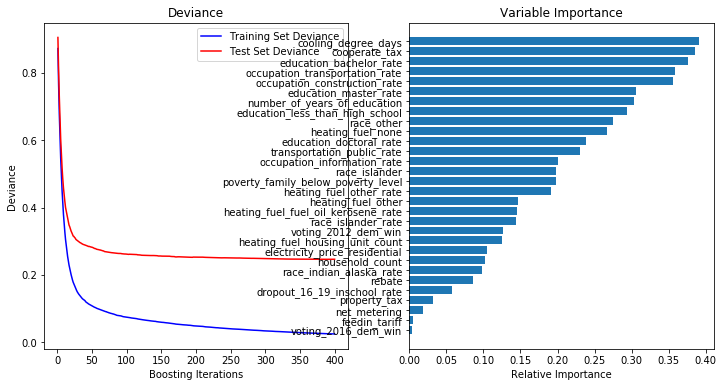

In [102]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
ik = ik-1
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_scaled, d_results_nopca_bestmodel[ik][model]['model'].predict(X_test_scaled))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'][0],), dtype=np.float64)

for i, y_pred in enumerate(d_results_nopca_bestmodel[ik][model]['model'].staged_predict(X_test_scaled)):
    test_score[i] = d_results_nopca_bestmodel[ik][model]['model'].loss_(y_test_scaled, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators'][0]) + 1, d_results_nopca_bestmodel[ik][model]['model'].train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators'][0]) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = d_results_nopca_bestmodel[ik][model]['model'].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[:30], feature_importance[sorted_idx][:30], align='center')
plt.yticks(pos[:30], X_test_scaled.columns[sorted_idx][:30])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')